In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab/pytorch-mnist-GAN')

In [3]:
!pip install torchvision==0.2.1

     |████████████████████████████████| 61kB 5.6MB/s 
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
# !pip install tensorflow
# !pip install tensorflow-gpu
# !pip install pytorch-transformers


     |████████████████████████████████| 454.3MB 32kB/s 
     |████████████████████████████████| 6.0MB 30.6MB/s 
     |████████████████████████████████| 4.0MB 34.5MB/s 
     |████████████████████████████████| 4.0MB 31.5MB/s 
     |████████████████████████████████| 471kB 44.0MB/s 
     |████████████████████████████████| 1.2MB 35.0MB/s 
     |████████████████████████████████| 4.9MB 35.3MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio

In [4]:
# Lookahead optimizer
from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer


class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(param_state['cached_params'], alpha=1.0 - self.la_alpha)  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [5]:
path = '/content/gdrive/My Drive/Colab/pytorch-mnist-GAN'
checkpoint_path = path + '/checkpoints/'

In [6]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

In [7]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_dataset = datasets.MNIST(root= path + '/mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root= path +'/mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [9]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [10]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)# build network



In [12]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [13]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [14]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002

G_optimizer = optim.Adam(G.parameters(), lr = lr)
G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)

D_optimizer = optim.Adam(D.parameters(), lr = lr)
D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)

In [15]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [16]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [17]:
# https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

G_loss_per_epoch = []
D_loss_per_epoch = []

n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    G_loss = torch.mean(torch.FloatTensor(G_losses))
    D_loss = torch.mean(torch.FloatTensor(D_losses))

    G_loss_per_epoch.append(G_loss.item())
    D_loss_per_epoch.append(D_loss.item())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, D_loss, G_loss))
    

    # # Save checkpoint at each epoch for G and D.
    # G_checkpoint = {'epoch': epoch,
    #                 'model': G,
    #                 'model_state_dict': G.state_dict(),
    #                 'optimizer_state_dict' : G_optimizer.state_dict(),
    #                 'loss': G_loss}

    # D_checkpoint = {'epoch': epoch,
    #                 'model': D,
    #                 'model_state_dict': D.state_dict(),
    #                 'optimizer_state_dict' : D_optimizer.state_dict(),
    #                 'loss': D_loss}

    # torch.save(G_checkpoint, checkpoint_path + 'G_checkpoint_epoch_{}.pth'.format(epoch))
    # torch.save(D_checkpoint, checkpoint_path + 'D_checkpoint_epoch_{}.pth'.format(epoch))

    samples_per_epoch = 1
    for sample_nbr in range(1, samples_per_epoch+1):
      with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28), path + '/samples/epoch_{}_sample_{}'.format(epoch, sample_nbr) + '.png')

[1/200]: loss_d: 1.130, loss_g: 1.702
[2/200]: loss_d: 1.252, loss_g: 1.059
[3/200]: loss_d: 0.936, loss_g: 1.710
[4/200]: loss_d: 0.572, loss_g: 2.663
[5/200]: loss_d: 0.456, loss_g: 3.428
[6/200]: loss_d: 0.512, loss_g: 3.112
[7/200]: loss_d: 0.458, loss_g: 3.160
[8/200]: loss_d: 0.443, loss_g: 3.162
[9/200]: loss_d: 0.488, loss_g: 3.024
[10/200]: loss_d: 0.505, loss_g: 2.850
[11/200]: loss_d: 0.533, loss_g: 2.629
[12/200]: loss_d: 0.578, loss_g: 2.487
[13/200]: loss_d: 0.578, loss_g: 2.434
[14/200]: loss_d: 0.658, loss_g: 2.225
[15/200]: loss_d: 0.650, loss_g: 2.193
[16/200]: loss_d: 0.693, loss_g: 2.146
[17/200]: loss_d: 0.674, loss_g: 2.164
[18/200]: loss_d: 0.701, loss_g: 2.075
[19/200]: loss_d: 0.754, loss_g: 1.994
[20/200]: loss_d: 0.786, loss_g: 1.915
[21/200]: loss_d: 0.800, loss_g: 1.837
[22/200]: loss_d: 0.854, loss_g: 1.711
[23/200]: loss_d: 0.864, loss_g: 1.691
[24/200]: loss_d: 0.876, loss_g: 1.671
[25/200]: loss_d: 0.891, loss_g: 1.617
[26/200]: loss_d: 0.904, loss_g: 1

KeyboardInterrupt: ignored

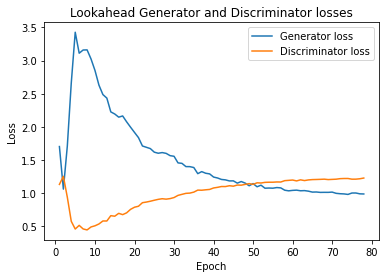

In [18]:
import matplotlib. pyplot as plt

plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator losses')
plt.show()

Load saved checkpoint:

In [ ]:
## KAGGLE SITE


# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = checkpoint['model']
#     model.load_state_dict(checkpoint['state_dict'])
#     for parameter in model.parameters():
#         parameter.requires_grad = False
    
#     model.eval()
    
#     return model


# model = load_checkpoint('checkpoint.pth')
# print(model)


In [ ]:
## PYTORCH SITE


# model = Net()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()